In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
LABELS = [0, 1, 1, 0]
CENTERS = [(-3, -3), (-3, 3), (3, -3), (3, 3)]

In [3]:
def get_toy_data(batch_size, labels, centers):
    if len(CENTERS) != len(LABELS):
        print("Error: LEN(centers) is not equal to LEN(labels)")
    else:
        x_data = []
        y_targets = np.zeros(batch_size)
        n_centers = len(CENTERS)
        
        for batch_i in range(batch_size):
            ### Randomly select one combination from n center-label combinations.
            center_idx = np.random.randint(0, n_centers)
            ### Add one sample to x_data
            x_data.append(np.random.normal(loc=CENTERS[center_idx]))
            ### Add one sample to y_data
            y_targets[batch_i] = LABELS[center_idx]
        return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

# 1. Single Layer Perceptron
## 2.1 The Model (Perceptron) and Activate Function (Sigmoid)
### - The Perceptron class has one inheritance class [nn.Module - The base class for all neural network modules.](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
### - The [Linear (nn.Linear)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class in the torch.nn module is applied.
### - The activation function is the [sigmoid (torch.sigmoid)](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) function.
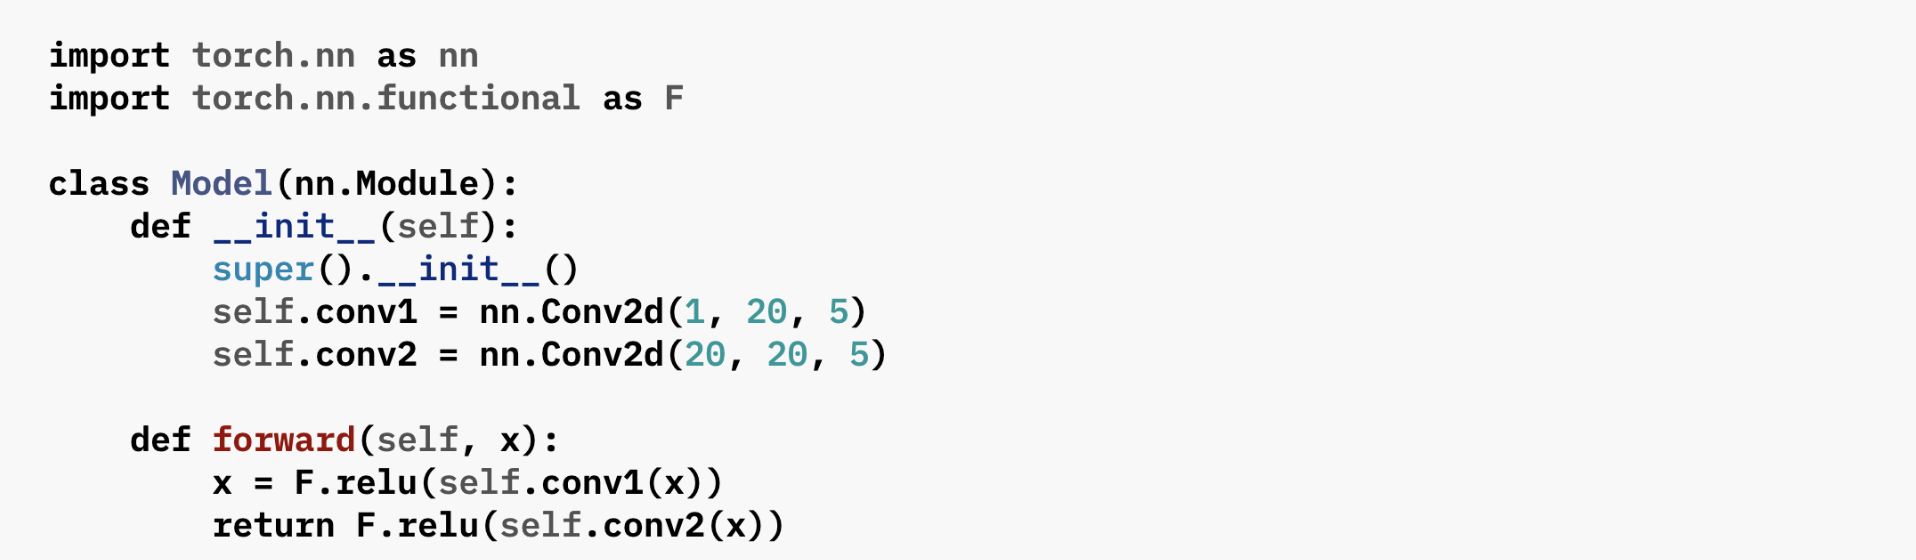


In [4]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        ### super() invokes the constructor of the parent class nn.Module for the Perceptron class.
        ### .__init__() calls the constructor of the parent class, executing the initialization 
        ### operations of the parent class. 
        super(Perceptron, self).__init__()
        
        ### creates a linear layer (nn.Linear)
        ### "input_dim" represents the number of input features
        ### "1" indicates the number of output features for the linear layer
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x, apply_sigmoid=False):
        """The forward pass of the MLP
        Args:
            x (torch.Tensor): an input data tensor.
            apply_softmax: if true, return a probability; if false, return a logit   
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        output = self.fc1(x)
        if apply_sigmoid:
            output = torch.sigmoid(output)
        return output

## A quick example of Perceptron
### Create the x-data and the label


In [5]:
LABELS  = [0,1]
CENTERS = [(3,3),(3,-3)]
x_data, y_data  = get_toy_data(batch_size=10,labels = LABELS,centers = CENTERS)

/var/folders/6s/wxmy299j1592tl76rwp6kg3h0000gn/T/ipykernel_91271/3971807120.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391830591/work/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)


### The parameters (initialized values)



In [6]:
input_dim  = x_data.shape[1]
perceptron = Perceptron(input_dim=input_dim)
for name, param in perceptron.named_parameters():
    print("Parameter name:", name)
    print("Parameter values:")
    print(param)
    print("Parameter shapes:",param.shape)
    print('-'*60)


Parameter name: fc1.weight
Parameter values:
Parameter containing:
tensor([[-0.2899, -0.5510]], requires_grad=True)
Parameter shapes: torch.Size([1, 2])
------------------------------------------------------------
Parameter name: fc1.bias
Parameter values:
Parameter containing:
tensor([-0.2713], requires_grad=True)
Parameter shapes: torch.Size([1])
------------------------------------------------------------


### Perform a computation using forward() function



In [7]:
print('does not apply softmax')
print(perceptron(x_data).view(1,10))

print('-'*80)

print('apply softmax')
print(perceptron(x_data,apply_sigmoid=True).view(1,10))

does not apply softmax
tensor([[-3.0194, -2.8501, -2.4576, -3.1310, -3.6599,  0.0763,  0.5111,  0.2835,
         -2.9638,  0.7518]], grad_fn=<ViewBackward0>)
--------------------------------------------------------------------------------
apply softmax
tensor([[0.0466, 0.0547, 0.0789, 0.0418, 0.0251, 0.5191, 0.6251, 0.5704, 0.0491,
         0.6796]], grad_fn=<ViewBackward0>)


### Perform a computation step by step (equivalent to running the forward function)

In [8]:
###### The lines above are equivalent to running the perceptron and sigmoid separately.
wx_b   = np.dot(x_data,list(perceptron.parameters())[0].detach().numpy().T)\
         +list(perceptron.parameters())[1].detach().numpy()
output = 1/(1+np.exp(-wx_b))


print('-'*80);print('The learnable parameters "weights" and "bias" in the Linear layer.')
print(list(perceptron.parameters()))

print('-'*80);print('wx+b, before sigmoid')
print(wx_b)

print('-'*80);print('Output, after sigmoid')
print(output)

--------------------------------------------------------------------------------
The learnable parameters "weights" and "bias" in the Linear layer.
[Parameter containing:
tensor([[-0.2899, -0.5510]], requires_grad=True), Parameter containing:
tensor([-0.2713], requires_grad=True)]
--------------------------------------------------------------------------------
wx+b, before sigmoid
[[-3.0194201 ]
 [-2.8501313 ]
 [-2.4575658 ]
 [-3.1310282 ]
 [-3.6599216 ]
 [ 0.07629773]
 [ 0.5110538 ]
 [ 0.2835479 ]
 [-2.9638264 ]
 [ 0.7517526 ]]
--------------------------------------------------------------------------------
Output, after sigmoid
[[0.04655621]
 [0.05467454]
 [0.07888704]
 [0.04184537]
 [0.02508888]
 [0.5190652 ]
 [0.62505347]
 [0.5704158 ]
 [0.04908709]
 [0.6795604 ]]


## 2.2 The Model (Multilayer Perceptron, MLP) and Activate Function (Softmax)
### Example: 
### MultilayerPerceptron(input_size=2, hidden_size=5, num_hidden_layers=3, output_size=2)
### - the size of the input is 2: two features x1, x2
### - the hidden layer is 5 - in each hidden layer there are 5 units
### - the number of  hidden layer is 3 - there are three hidden layers: HL1 (2 to 5), HL2 (5 to 5), HL3 (5 to 5) 
### - the size of the output is 2: two possible labels in y 

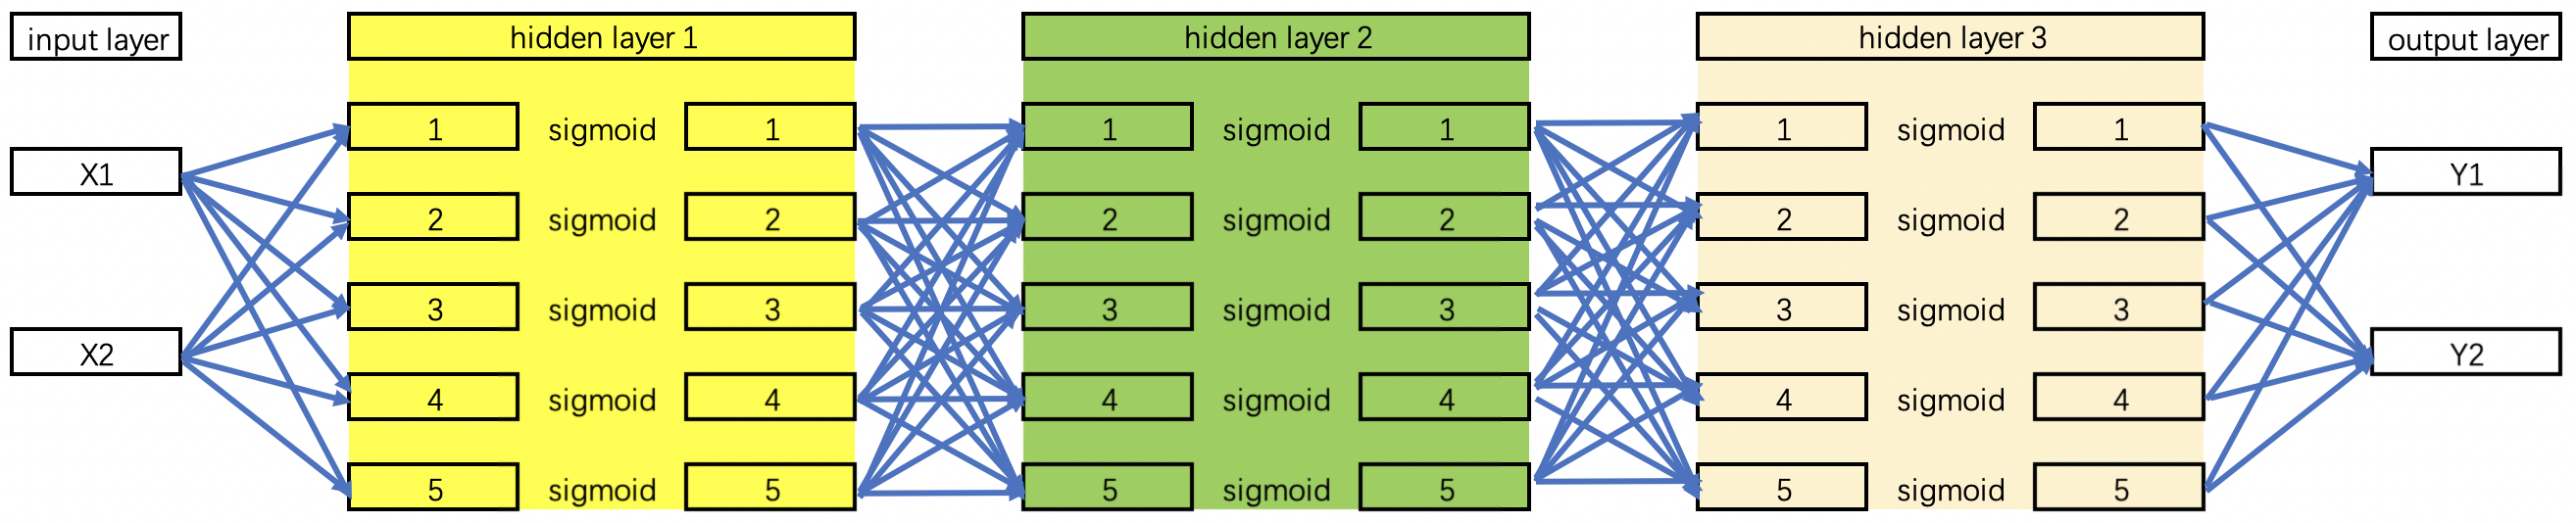


In [9]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.
        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list    = nn.ModuleList()
        
        ### the input size of the first hidden layer - input_size
        ### the output size of the first hidden layer - hidden_size
        interim_input_size  = input_size
        interim_output_size = hidden_size
        
        for _ in range(num_hidden_layers):
            ### in the first hidden layer, interim_input_size = input_size
            ### in all the other hidden layers, interim_input_size = hidden_size
            ### in all hidden layers, interim_output_size = hidden_size
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
        
        ### in the output layer, input size = hidden_size, output size = output_size
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        ### define the list that stores the outputs in each hidden layer and output layer
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        ### the first element id the x data
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            ### modules represents the defined layers in __init__
            x = module(x)
            ### store the intermediate outputs in each layer
            self.last_forward_cache.append(x.to("cpu").data.numpy())
        
        ### store the outputs in final layer
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

## A quick example of MultilayerPerceptron
### Create the x-data and the label


In [10]:
LABELS  = [0,1]
CENTERS = [(3,3),(3,-3)]
x_data, y_data  = get_toy_data(batch_size=10,labels = LABELS,centers = CENTERS)

### The parameters (initialized values)


In [11]:
input_size        = 2
hidden_size       = 5
num_hidden_layers = 3
output_size       = 2

mlp_2532 = MultilayerPerceptron(input_size=input_size, 
                                hidden_size=hidden_size, 
                                num_hidden_layers=num_hidden_layers, 
                                output_size=output_size)

In [12]:
for name, param in mlp_2532.named_parameters():
    print("Parameter name:", name)
    print("Parameter values:")
    print(param)
    print("Parameter shapes:",param.shape)
    print('-'*60)

Parameter name: module_list.0.weight
Parameter values:
Parameter containing:
tensor([[ 0.1927,  0.4745],
        [-0.2350, -0.1973],
        [-0.5035, -0.0168],
        [-0.6069, -0.3208],
        [ 0.3255,  0.4802]], requires_grad=True)
Parameter shapes: torch.Size([5, 2])
------------------------------------------------------------
Parameter name: module_list.0.bias
Parameter values:
Parameter containing:
tensor([-0.4430, -0.3055, -0.0294,  0.3392, -0.5773], requires_grad=True)
Parameter shapes: torch.Size([5])
------------------------------------------------------------
Parameter name: module_list.2.weight
Parameter values:
Parameter containing:
tensor([[ 0.1366, -0.4141, -0.3075, -0.2150, -0.1032],
        [-0.2203,  0.3692,  0.2910,  0.3546, -0.2331],
        [ 0.0482,  0.2827, -0.2118, -0.3024, -0.0351],
        [ 0.3244,  0.2366,  0.2000,  0.4030, -0.3991],
        [-0.3279, -0.1597, -0.3483, -0.3340,  0.0636]], requires_grad=True)
Parameter shapes: torch.Size([5, 5])
----------

### Perform a computation using forward() function

In [13]:
print('At first, mlp_2532.last_forward_cache is an empty list')
mlp_2532.last_forward_cache

At first, mlp_2532.last_forward_cache is an empty list


[]

In [14]:
print('does not apply softmax')
print(mlp_2532(x_data,apply_softmax=False))

print('-'*80)

print('apply softmax')
print(mlp_2532(x_data,apply_softmax=True))

does not apply softmax
tensor([[0.4937, 0.0061],
        [0.4899, 0.0150],
        [0.4890, 0.0167],
        [0.4971, 0.0019],
        [0.4889, 0.0167],
        [0.4971, 0.0005],
        [0.4876, 0.0187],
        [0.4887, 0.0175],
        [0.4916, 0.0125],
        [0.4888, 0.0171]], grad_fn=<AddmmBackward0>)
--------------------------------------------------------------------------------
apply softmax
tensor([[0.6195, 0.3805],
        [0.6165, 0.3835],
        [0.6159, 0.3841],
        [0.6213, 0.3787],
        [0.6159, 0.3841],
        [0.6216, 0.3784],
        [0.6151, 0.3849],
        [0.6157, 0.3843],
        [0.6176, 0.3824],
        [0.6158, 0.3842]], grad_fn=<SoftmaxBackward0>)


In [15]:
### Now there are 8 elements in mlp_2532.last_forward_cache
### 1. x_data
### 2. wx+b in the 1st hidden layer
### 3. Sigmoid(wx+b) in the the 1st hidden layer
### 4. wx+b in the 2nd hidden layer
### 5. Sigmoid(wx+b) in the the 2nd hidden layer
### 6. wx+b in the 3rd hidden layer
### 7. Sigmoid(wx+b) in the the 3rd hidden layer
### 8. wx+b in the the output layer
print('number of elements in mlp_2532.last_forward_cache:',len(mlp_2532.last_forward_cache))

number of elements in mlp_2532.last_forward_cache: 8


### Perform a computation step by step (equivalent to running the forward function)


### 1. last_forward_cache[0]: input to Hidden Layer 1 (x_data)


In [16]:
x_data

tensor([[ 3.8575, -3.1392],
        [ 3.2060,  2.1567],
        [ 3.4404,  3.0715],
        [ 2.3963, -2.2686],
        [ 3.5492,  2.9008],
        [ 4.3046, -6.2184],
        [ 4.6953,  2.8094],
        [ 3.3164,  4.1168],
        [ 2.4149,  2.0650],
        [ 3.5241,  3.2507]])

In [17]:
mlp_2532.last_forward_cache[0]

array([[ 3.8574777, -3.1391883],
       [ 3.2060132,  2.1566875],
       [ 3.4404488,  3.071471 ],
       [ 2.3962865, -2.2685814],
       [ 3.5491822,  2.9008148],
       [ 4.3046017, -6.2184353],
       [ 4.6952596,  2.8093934],
       [ 3.3164086,  4.116761 ],
       [ 2.414922 ,  2.0650134],
       [ 3.5240867,  3.250673 ]], dtype=float32)

### 2. last_forward_cache[1], wx+b of Hidden Layer 1


In [18]:
mlp_2532.last_forward_cache[1]


array([[-1.1893307 , -0.5926222 , -1.919024  , -0.99473757, -0.8291332 ],
       [ 1.1981213 , -1.4842403 , -1.679899  , -2.29841   ,  1.5020242 ],
       [ 1.6773677 , -1.719779  , -1.8132937 , -2.7341747 ,  2.0176463 ],
       [-1.0577409 , -0.42103398, -1.1979172 , -0.38724893, -0.8867116 ],
       [ 1.6173384 , -1.711663  , -1.8651774 , -2.7454145 ,  1.9710889 ],
       [-2.5643306 , -0.09025401, -2.0924687 , -0.2781996 , -2.1623213 ],
       [ 1.7947707 , -1.9629164 , -2.440701  , -3.4116416 ,  2.300274  ],
       [ 2.1494741 , -1.8968327 , -1.768384  , -2.9942493 ,  2.4792454 ],
       [ 1.0022023 , -1.2802777 , -1.2800403 , -1.7888832 ,  1.2004716 ],
       [ 1.778516  , -1.7747812 , -1.8584142 , -2.8424273 ,  2.1309314 ]],
      dtype=float32)

In [19]:
np.dot(mlp_2532.last_forward_cache[0],list(mlp_2532.parameters())[0].detach().numpy().T)\
+list(mlp_2532.parameters())[1].detach().numpy()


array([[-1.1893307 , -0.5926222 , -1.919024  , -0.99473757, -0.8291332 ],
       [ 1.1981213 , -1.4842403 , -1.679899  , -2.29841   ,  1.5020242 ],
       [ 1.6773677 , -1.719779  , -1.8132937 , -2.7341747 ,  2.0176463 ],
       [-1.0577409 , -0.42103398, -1.1979172 , -0.38724893, -0.8867116 ],
       [ 1.6173384 , -1.711663  , -1.8651774 , -2.7454145 ,  1.9710889 ],
       [-2.5643306 , -0.09025401, -2.0924687 , -0.2781996 , -2.1623213 ],
       [ 1.7947707 , -1.9629164 , -2.440701  , -3.4116416 ,  2.300274  ],
       [ 2.1494741 , -1.8968327 , -1.768384  , -2.9942493 ,  2.4792454 ],
       [ 1.0022023 , -1.2802777 , -1.2800403 , -1.7888832 ,  1.2004716 ],
       [ 1.778516  , -1.7747812 , -1.8584142 , -2.8424273 ,  2.1309314 ]],
      dtype=float32)

### 3. last_forward_cache[2], Sigmoid(wx+b) of Hidden Layer 1, Input of Hidden Layer 2


In [20]:
mlp_2532.last_forward_cache[2]

array([[0.23337868, 0.3560334 , 0.12797044, 0.26997733, 0.3038284 ],
       [0.76819044, 0.18478781, 0.15710884, 0.09125473, 0.8178762 ],
       [0.84255564, 0.15189964, 0.14024052, 0.06098665, 0.8826374 ],
       [0.2577414 , 0.39626932, 0.23184595, 0.40437976, 0.2917889 ],
       [0.8344277 , 0.15294814, 0.13410072, 0.06034614, 0.877728  ],
       [0.07146962, 0.47745177, 0.10983098, 0.43089524, 0.10318544],
       [0.85751116, 0.12315177, 0.08012123, 0.03193361, 0.9088997 ],
       [0.89561963, 0.13046737, 0.1457434 , 0.04768635, 0.922674  ],
       [0.7314913 , 0.21750294, 0.21754336, 0.1432097 , 0.7686087 ],
       [0.8555135 , 0.14494874, 0.134888  , 0.05507408, 0.89387345]],
      dtype=float32)

In [21]:
1/(1+np.exp(-mlp_2532.last_forward_cache[1]))

array([[0.23337865, 0.3560334 , 0.12797044, 0.26997733, 0.3038284 ],
       [0.7681904 , 0.18478781, 0.15710884, 0.09125473, 0.81787616],
       [0.84255564, 0.15189962, 0.14024052, 0.06098664, 0.8826374 ],
       [0.2577414 , 0.39626932, 0.23184595, 0.40437976, 0.2917889 ],
       [0.8344277 , 0.15294814, 0.13410072, 0.06034614, 0.877728  ],
       [0.07146963, 0.47745177, 0.10983098, 0.43089524, 0.10318544],
       [0.85751116, 0.12315177, 0.08012123, 0.03193361, 0.9088997 ],
       [0.89561963, 0.13046737, 0.1457434 , 0.04768635, 0.922674  ],
       [0.7314913 , 0.21750294, 0.21754336, 0.1432097 , 0.7686087 ],
       [0.8555135 , 0.14494874, 0.13488801, 0.05507408, 0.89387345]],
      dtype=float32)

### 4. last_forward_cache[3], wx+b of Hidden Layer 2


In [22]:
mlp_2532.last_forward_cache[3]

array([[-0.643026  ,  0.08060601, -0.20561524, -0.1103725 , -0.31632704],
       [-0.52267313, -0.27512473, -0.19838935, -0.24877927, -0.38211423],
       [-0.49388868, -0.33438194, -0.19364683, -0.2738591 , -0.38114437],
       [-0.71595925,  0.17078091, -0.25528246, -0.01319599, -0.41257852],
       [-0.49290034, -0.33307377, -0.19207631, -0.27577442, -0.37660652],
       [-0.72372556,  0.25964057, -0.21688247,  0.00714561, -0.34281525],
       [-0.45791948, -0.3822045 , -0.1804567 , -0.31002676, -0.34914577],
       [-0.48073238, -0.3664294 , -0.19569418, -0.28195652, -0.39005017],
       [-0.5659014 , -0.20747358, -0.2176915 , -0.20025074, -0.41683933],
       [-0.48748344, -0.3460751 , -0.1924596 , -0.2792387 , -0.37972987]],
      dtype=float32)

In [23]:
np.dot(mlp_2532.last_forward_cache[2],list(mlp_2532.parameters())[2].detach().numpy().T)\
+list(mlp_2532.parameters())[3].detach().numpy()

array([[-0.643026  ,  0.08060601, -0.20561524, -0.1103725 , -0.31632704],
       [-0.52267313, -0.27512473, -0.19838935, -0.24877927, -0.38211423],
       [-0.49388868, -0.33438194, -0.19364683, -0.2738591 , -0.38114437],
       [-0.71595925,  0.17078091, -0.25528246, -0.01319599, -0.41257852],
       [-0.49290034, -0.33307377, -0.19207631, -0.27577442, -0.37660652],
       [-0.72372556,  0.25964057, -0.21688247,  0.00714561, -0.34281525],
       [-0.45791948, -0.3822045 , -0.1804567 , -0.31002676, -0.34914577],
       [-0.48073238, -0.3664294 , -0.19569418, -0.28195652, -0.39005017],
       [-0.5659014 , -0.20747358, -0.2176915 , -0.20025074, -0.41683933],
       [-0.48748344, -0.3460751 , -0.1924596 , -0.2792387 , -0.37972987]],
      dtype=float32)

### 5. last_forward_cache[4], Sigmoid(wx+b) of Hidden Layer 2, , Input of Hidden Layer 3


In [24]:
mlp_2532.last_forward_cache[4]

array([[0.34456283, 0.5201406 , 0.4487765 , 0.47243485, 0.42157114],
       [0.3722274 , 0.43164945, 0.45056468, 0.438124  , 0.40561706],
       [0.37897792, 0.41717482, 0.451739  , 0.43195993, 0.40585092],
       [0.3282834 , 0.54259175, 0.4365237 , 0.49670103, 0.398294  ],
       [0.37921056, 0.4174929 , 0.45212802, 0.43149003, 0.40694565],
       [0.32657313, 0.5645479 , 0.44599095, 0.5017864 , 0.4151258 ],
       [0.3874795 , 0.4055953 , 0.45500782, 0.42310822, 0.4135896 ],
       [0.38207918, 0.4094041 , 0.45123196, 0.4299742 , 0.40370524],
       [0.3621831 , 0.4483169 , 0.445791  , 0.45010394, 0.3972733 ],
       [0.3804866 , 0.4143345 , 0.45203307, 0.4306404 , 0.40619203]],
      dtype=float32)

In [25]:
1/(1+np.exp(-mlp_2532.last_forward_cache[3]))

array([[0.34456283, 0.5201406 , 0.4487765 , 0.47243485, 0.42157114],
       [0.37222734, 0.43164945, 0.45056468, 0.438124  , 0.40561706],
       [0.37897792, 0.41717482, 0.451739  , 0.43195993, 0.40585095],
       [0.3282834 , 0.54259175, 0.4365237 , 0.49670103, 0.398294  ],
       [0.37921056, 0.4174929 , 0.45212802, 0.43149003, 0.40694565],
       [0.32657313, 0.5645479 , 0.44599095, 0.5017864 , 0.4151258 ],
       [0.3874795 , 0.4055953 , 0.45500788, 0.42310822, 0.4135896 ],
       [0.3820792 , 0.4094041 , 0.45123196, 0.4299742 , 0.40370524],
       [0.3621831 , 0.44831684, 0.445791  , 0.45010394, 0.3972733 ],
       [0.3804866 , 0.4143345 , 0.4520331 , 0.43064046, 0.40619206]],
      dtype=float32)

### 6. last_forward_cache[5], wx+b of Hidden Layer 3


In [26]:
mlp_2532.last_forward_cache[5]

array([[-0.44262105, -0.1568018 ,  0.07963894,  0.2909624 , -0.28192383],
       [-0.4379139 , -0.11824559,  0.05094959,  0.32927346, -0.30962545],
       [-0.43598425, -0.11043856,  0.04600234,  0.335427  , -0.31550622],
       [-0.45569164, -0.18354413,  0.08582114,  0.28455415, -0.26289028],
       [-0.43554434, -0.10995379,  0.04612997,  0.33514047, -0.31585982],
       [-0.4533657 , -0.18482979,  0.09454364,  0.2755174 , -0.26174638],
       [-0.43102288, -0.09986067,  0.04191047,  0.33924866, -0.3235618 ],
       [-0.43586564, -0.10767803,  0.04317032,  0.33900532, -0.31768686],
       [-0.44366488, -0.13224092,  0.05626938,  0.3233118 , -0.29934785],
       [-0.4354702 , -0.10875054,  0.04500531,  0.33659858, -0.3167962 ]],
      dtype=float32)

In [27]:
np.dot(mlp_2532.last_forward_cache[4],list(mlp_2532.parameters())[4].detach().numpy().T)\
+list(mlp_2532.parameters())[5].detach().numpy()


array([[-0.44262105, -0.1568018 ,  0.07963894,  0.2909624 , -0.28192383],
       [-0.4379139 , -0.11824559,  0.05094959,  0.32927346, -0.30962545],
       [-0.43598425, -0.11043856,  0.04600234,  0.335427  , -0.31550622],
       [-0.45569164, -0.18354413,  0.08582114,  0.28455415, -0.26289028],
       [-0.43554434, -0.10995379,  0.04612997,  0.33514047, -0.31585982],
       [-0.4533657 , -0.18482979,  0.09454364,  0.2755174 , -0.26174638],
       [-0.43102288, -0.09986067,  0.04191047,  0.33924866, -0.3235618 ],
       [-0.43586564, -0.10767803,  0.04317032,  0.33900532, -0.31768686],
       [-0.44366488, -0.13224092,  0.05626938,  0.3233118 , -0.29934785],
       [-0.4354702 , -0.10875054,  0.04500531,  0.33659858, -0.3167962 ]],
      dtype=float32)

### 7. last_forward_cache[6], Sigmoid(wx+b) of Hidden Layer 3


In [28]:
mlp_2532.last_forward_cache[6]

array([[0.39111662, 0.46087965, 0.5198992 , 0.5722317 , 0.42998216],
       [0.39223817, 0.470473  , 0.51273465, 0.5815826 , 0.42320615],
       [0.39269826, 0.47241837, 0.5114986 , 0.5830793 , 0.42177132],
       [0.3880084 , 0.45424235, 0.5214421 , 0.5706624 , 0.43465334],
       [0.39280316, 0.47253922, 0.51153046, 0.5830096 , 0.42168507],
       [0.38856083, 0.45392364, 0.52361834, 0.56844693, 0.43493447],
       [0.3938821 , 0.47505555, 0.51047605, 0.584008  , 0.41980797],
       [0.39272657, 0.4731065 , 0.51079094, 0.5839489 , 0.42123958],
       [0.39086804, 0.46698788, 0.51406366, 0.5801311 , 0.4257169 ],
       [0.39282086, 0.47283915, 0.5112494 , 0.583364  , 0.42145675]],
      dtype=float32)

In [29]:
1/(1+np.exp(-mlp_2532.last_forward_cache[5]))


array([[0.39111662, 0.46087965, 0.5198992 , 0.5722317 , 0.42998216],
       [0.39223817, 0.470473  , 0.51273465, 0.5815826 , 0.42320615],
       [0.39269826, 0.47241837, 0.5114986 , 0.5830793 , 0.42177132],
       [0.3880084 , 0.45424235, 0.5214421 , 0.5706624 , 0.43465334],
       [0.39280313, 0.47253922, 0.51153046, 0.5830096 , 0.42168507],
       [0.38856083, 0.45392364, 0.52361834, 0.56844693, 0.4349344 ],
       [0.3938821 , 0.47505555, 0.5104761 , 0.584008  , 0.41980797],
       [0.39272654, 0.4731065 , 0.5107909 , 0.5839489 , 0.42123958],
       [0.39086807, 0.46698788, 0.51406366, 0.5801312 , 0.4257169 ],
       [0.39282086, 0.47283915, 0.5112494 , 0.583364  , 0.42145675]],
      dtype=float32)

### 8. last_forward_cache[7], wx+b of Output Layer

In [30]:
mlp_2532.last_forward_cache[7]

array([[0.49366015, 0.00614701],
       [0.4898711 , 0.01499546],
       [0.48899448, 0.01669966],
       [0.4971413 , 0.00189173],
       [0.4889121 , 0.01674372],
       [0.49708837, 0.00054124],
       [0.4875852 , 0.01865044],
       [0.48872602, 0.01746248],
       [0.49162555, 0.012458  ],
       [0.4887945 , 0.01705982]], dtype=float32)

In [31]:
np.dot(mlp_2532.last_forward_cache[6],list(mlp_2532.parameters())[6].detach().numpy().T)\
+list(mlp_2532.parameters())[7].detach().numpy()


array([[0.49366015, 0.00614701],
       [0.4898711 , 0.01499546],
       [0.48899448, 0.01669966],
       [0.4971413 , 0.00189173],
       [0.4889121 , 0.01674372],
       [0.49708837, 0.00054124],
       [0.4875852 , 0.01865044],
       [0.48872602, 0.01746248],
       [0.49162555, 0.012458  ],
       [0.4887945 , 0.01705982]], dtype=float32)

In [32]:
print('Same output with using the forward function')
print(mlp_2532(x_data,apply_softmax=False))

Same output with using the forward function
tensor([[0.4937, 0.0061],
        [0.4899, 0.0150],
        [0.4890, 0.0167],
        [0.4971, 0.0019],
        [0.4889, 0.0167],
        [0.4971, 0.0005],
        [0.4876, 0.0187],
        [0.4887, 0.0175],
        [0.4916, 0.0125],
        [0.4888, 0.0171]], grad_fn=<AddmmBackward0>)
